# Sasol Customer Retention Recruitment Competition
Can you build a model to predict whether a customer will become inactive?

# **FEATURE ENGINEERING NOTEBOOK - VERSION 5**

In [ ]:
!gdown --id 1lrRB0AscVCFZeFyGNrYDuwSQn32HlXVn
!unzip -qq /content/Sasol_Customer_Retention.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import warnings
import random
import keras
import sklearn
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import missingno
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_seed(SEED)

random_state = SEED

In [5]:
%%time
DATA_PATH = '/content/'
OUTPUT_PATH = '/content/'

train = pd.read_csv(DATA_PATH + 'Train.csv')
test = pd.read_csv(DATA_PATH + 'Test.csv')
submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')
vr = pd.read_csv("/content/VariableDescription.csv")

ID = test['ID']
diat = train[['Target']]

print(train.shape, test.shape)

(1507834, 19) (380127, 18)
CPU times: user 4.55 s, sys: 643 ms, total: 5.19 s
Wall time: 5.87 s


In [6]:
vr

,Variable Definitions,Unnamed: 2
0,NaN,The churn dataset includes 19 variables includ...
1,ID,NaN
2,region,the location of each client
3,tenure,duration in the network
4,Amount,top-up amount
5,refill_frequency,number of times the customer refilled
6,revenue,monthly revenue of each client
7,arpu_segment,revenue over 90 days / 3
8,frequency,number of times the client has made an revenue
9,data_volume,number of connections


In [7]:
train.head()

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,ID_YEB05X4KUGPQ,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
1,ID_Z9IQ9QH52KVN,Nebula,K > 24 month,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,NaN,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,31.0,0
2,ID_YZSU7B7M35QS,Celestial,K > 24 month,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,NaN,1.0,NaN,NaN,NO,61,NaN,NaN,0
3,ID_QS4F5LEX29KM,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN,0
4,ID_8IYIC9PFU8U1,Eclipsara,K > 24 month,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,NaN,NaN,NO,62,Mixt 250F=Unlimited_call24H,31.0,0


In [8]:
test.head()

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack
0,ID_LZ8K373W7EWV,Droidika,K > 24 month,2008.55,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,NaN,NaN,NO,59,On net 200F=Unlimited _call24H,11.0
1,ID_04KNWHGV5783,Luminous,K > 24 month,2991.45,14.0,2991.45,997.01,17.0,NaN,99.0,100.0,84.0,NaN,NaN,NO,49,All-net 500F=2000F;5d,12.0
2,ID_CXS07G6VLB2U,Astral,K > 24 month,1581.20,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,NaN,NaN,NO,13,Jokko_Daily,6.0
3,ID_N3NFJJVHS25K,Eclipsara,K > 24 month,2564.10,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,NaN,NaN,NaN,NO,53,All-net 500F=2000F;5d,13.0
4,ID_R36J4ROT93E9,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN


**Checking for categorical features:**

In [9]:
categorical_feats= train.dtypes[train.dtypes == "object"].index; categorical_feats

Index(['ID', 'region', 'tenure', 'mrg', 'top_pack'], dtype='object')

**Checking for numerical features:**

In [10]:
numerical_feats= train.dtypes[train.dtypes != "object"].index; numerical_feats

Index(['Amount', 'refill_frequency', 'revenue', 'arpu_segment', 'frequency',
       'data_volume', 'on_net', 'Procuct_1', 'Procuct_2', 'zone1', 'zone2',
       'regularity', 'freq_top_pack', 'Target'],
      dtype='object')

In [11]:
train['Target'].value_counts()

0    1225319
1     282515
Name: Target, dtype: int64

# Target Distribution:

In [12]:
fig = px.histogram(train, x=train['Target'], color=train['Target'],)
fig.update_layout(
    title_text='Target distribution',   # title of plot
    xaxis_title_text='Value',           # xaxis label
    yaxis_title_text='Count',           # yaxis label
    bargap=0.2,                         # gap between bars of adjacent location coordinates

)
fig.show()

**In the target variable, all Classes has more data points.**
# Correlation Matrix

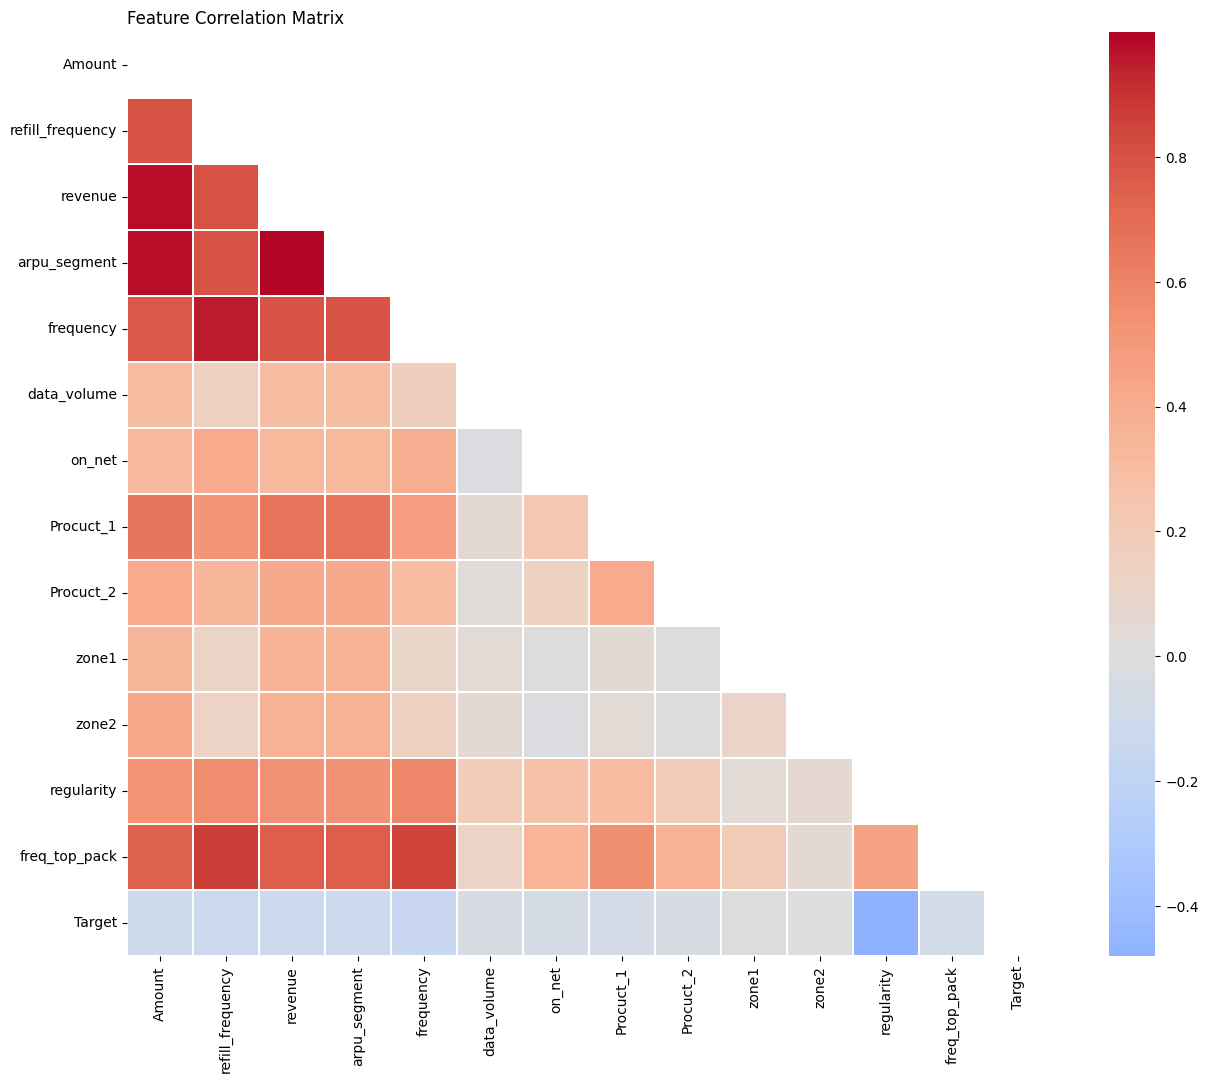

In [13]:
rename_labels = {val:idx for idx, val in enumerate(sorted(train['Target'].unique()))}
train['Target'] = train['Target'].map(rename_labels)
fig, ax = plt.subplots(figsize=(15 , 12))
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr,square=True, center=0,
            linewidth=0.2, cmap='coolwarm',
           mask=mask, ax=ax)

ax.set_title('Feature Correlation Matrix ', loc='left')
plt.show()

In [14]:
train.describe()

,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,Target
count,978320.000000,978320.000000,999713.000000,999713.000000,999713.000000,7.660280e+05,957192.000000,881271.000000,604784.000000,118986.000000,95505.000000,1.507834e+06,876011.000000,1.507834e+06
mean,2361.212767,11.521423,2352.073152,784.027307,13.967657,3.354667e+03,278.000929,95.325088,23.146017,8.092187,7.465515,2.804414e+01,9.263913,1.873648e-01
std,3028.954909,13.266779,3053.176864,1017.723634,14.682316,1.330460e+04,874.412483,203.328016,63.506893,40.739423,32.145740,2.228078e+01,12.268658,3.902042e-01
min,4.270000,1.000000,0.430000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000e+00
25%,427.350000,2.000000,427.350000,142.310000,3.000000,0.000000e+00,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000e+00
50%,1282.050000,7.000000,1282.050000,427.350000,9.000000,2.560000e+02,27.000000,29.000000,6.000000,1.000000,2.000000,2.400000e+01,5.000000,0.000000e+00
75%,3141.030000,16.000000,3146.580000,1048.720000,20.000000,2.879000e+03,156.000000,99.000000,20.000000,3.000000,5.000000,5.100000e+01,12.000000,0.000000e+00
max,124145.300000,133.000000,113696.580000,37898.720000,91.000000,1.823866e+06,50809.000000,12040.000000,4174.000000,4792.000000,3143.000000,6.200000e+01,629.000000,1.000000e+00


In [15]:
train.shape, test.shape

((1507834, 19), (380127, 18))

In [16]:
print(train.mrg.value_counts(dropna = False), 'Train length:', len(train), '\n')
print(test.mrg.value_counts(dropna = False), 'Test length:', len(test))

NO    1507834
Name: mrg, dtype: int64 Train length: 1507834 

NO    380127
Name: mrg, dtype: int64 Test length: 380127


In [17]:
train.drop(['ID', 'mrg',], 1, inplace = True)
test.drop(['ID', 'mrg',], 1, inplace = True)

# **FEATURE ENGINEERING:**

In [18]:
data = pd.concat([train,test],axis=0)
data = data.reset_index(drop=True)

In [27]:
# train['top_pack'].hist() #value_counts()

In [28]:
train['tenure'].value_counts()

K > 24 month     1430080
I 18-21 month      31653
H 15-18 month      18373
G 12-15 month      10468
J 21-24 month       8907
F 9-12 month        6524
E 6-9 month         1288
D 3-6 month          541
Name: tenure, dtype: int64

In [29]:
def tenure(x):
    'function to encode the tenure based on the lowest amount of month spent'
    if x == 'K > 24 month':
        return 24
    elif x == 'H 15-18 month':
        return 15
    elif x == 'G 12-15 month':
        return 12
    elif x == 'J 21-24 month':
        return 21
    elif x == 'I 18-21 month':
        return 18
    elif x == 'E 6-9 month':
        return 6
    elif x == 'F 9-12 month':
        return 9
    elif x == 'D 3-6 month':
        return 3
    else:
        pass

In [30]:
data.tenure = data.tenure.apply(tenure)

In [31]:
numerical_feats

Index(['Amount', 'refill_frequency', 'revenue', 'arpu_segment', 'frequency',
       'data_volume', 'on_net', 'Procuct_1', 'Procuct_2', 'zone1', 'zone2',
       'regularity', 'freq_top_pack', 'Target'],
      dtype='object')

In [32]:
categorical_feats

Index(['ID', 'region', 'tenure', 'mrg', 'top_pack'], dtype='object')

In [33]:
agg_columns = ['revenue','Amount','arpu_segment','data_volume','on_net']

### **Aggregation of few numerical features:**

In [34]:
id_agg_tags = ['region', 'tenure']

qnames = {'25%': 'p25', '50%': 'p50', '75%': 'p75'}

agg_columns = agg_columns

data[agg_columns] = data[agg_columns].astype('float32')

for id_tag in id_agg_tags:
    print(f"\nGrouping with {id_tag}")

    temp = data[[id_tag, *agg_columns]].groupby(id_tag)[agg_columns].describe().rename(columns=qnames)

    temp.columns = ["_".join(col) for col in temp.columns]
    temp = temp.drop(columns=temp.columns[temp.columns.str.endswith('_count')].tolist())

    temp = temp.add_prefix(f"{id_tag}_").reset_index()
    display(temp.head())

    data = data.merge(temp, on=id_tag, how='left')


Grouping with region


,region,region_revenue_mean,region_revenue_std,region_revenue_min,region_revenue_p25,region_revenue_p50,region_revenue_p75,region_revenue_max,region_Amount_mean,region_Amount_std,...,region_data_volume_p50,region_data_volume_p75,region_data_volume_max,region_on_net_mean,region_on_net_std,region_on_net_min,region_on_net_p25,region_on_net_p50,region_on_net_p75,region_on_net_max
0,Astral,1943.099121,2462.196533,0.43,427.350006,1068.380005,2563.250000,32286.320312,1941.844727,2438.002686,...,1.0,661.25,145658.0,365.502258,918.180481,0.0,8.0,59.0,281.00,16502.0
1,Celestial,2036.722778,2528.321289,0.43,427.350006,1164.530029,2666.669922,56698.289062,2033.509766,2512.337402,...,3.0,911.50,110463.0,388.761536,1087.229980,0.0,8.0,51.0,255.00,24293.0
2,Droidika,2506.113281,2997.788086,0.43,521.369995,1495.729980,3418.800049,88849.148438,2499.209717,2983.258789,...,306.0,3239.00,348797.0,331.611725,969.586426,0.0,6.0,37.0,205.00,50809.0
3,Eclipsara,2554.374023,2897.200928,0.43,598.289978,1607.050049,3508.550049,81024.359375,2544.090820,2864.839111,...,126.0,2210.00,208079.0,392.827820,1091.975708,0.0,8.0,54.0,277.00,45011.0
4,Eternum,2453.088135,3050.694580,0.85,427.779999,1355.130005,3205.129883,22702.140625,2491.280029,2947.393799,...,9.0,1034.00,55139.0,341.763733,884.262573,0.0,7.0,41.0,253.25,9236.0



Grouping with tenure


,tenure,tenure_revenue_mean,tenure_revenue_std,tenure_revenue_min,tenure_revenue_p25,tenure_revenue_p50,tenure_revenue_p75,tenure_revenue_max,tenure_Amount_mean,tenure_Amount_std,...,tenure_data_volume_p50,tenure_data_volume_p75,tenure_data_volume_max,tenure_on_net_mean,tenure_on_net_std,tenure_on_net_min,tenure_on_net_p25,tenure_on_net_p50,tenure_on_net_p75,tenure_on_net_max
0,3,1140.955444,1729.574829,8.55,213.679993,507.690002,1232.050049,15726.500000,1210.845337,1895.814453,...,355.0,1442.75,274889.0,108.943718,370.772369,0.0,3.0,8.0,34.0,3977.0
1,6,2980.923828,5660.617676,0.85,473.614990,1305.339966,3288.034912,64102.558594,2963.625244,5749.166504,...,491.5,4066.25,1326875.0,301.036652,978.594421,0.0,4.0,18.0,131.5,12874.0
2,9,2227.393555,3038.836182,0.85,425.640015,1238.890015,2848.290039,38333.328125,2230.030762,2976.885498,...,675.0,4391.00,1702309.0,269.461456,906.066650,0.0,2.0,18.0,121.5,20173.0
3,12,2105.974365,2988.507568,0.43,405.980011,1111.969971,2722.010010,66086.320312,2119.045898,2952.343018,...,465.0,4032.00,914746.0,234.758499,777.716614,0.0,2.0,18.0,112.0,13408.0
4,15,2026.761353,2679.085693,0.43,406.410004,1110.680054,2649.570068,61519.660156,2052.678711,2642.026611,...,250.0,3292.00,510333.0,282.861786,911.994019,0.0,3.0,23.0,131.0,14972.0


# Feature Intereactions:

In [35]:
data['On_net_zone12'] = data['on_net'] - (data['zone2'] + data['zone1'])
data['rev_freq']  = data['revenue'] * data['frequency']
data['data_vol_on_net'] = ((data['data_volume'] + 1) / (data['on_net'] + 1)).apply(np.log)

In [36]:
data['active_per_duration'] =  data['tenure'] / data['regularity']
data['income_left_after_top_up'] = data['revenue'] - data['Amount']
data['tenure_to_topup_frequency'] = data['tenure'] / data['refill_frequency']
data['income_in90days_perrevenue'] = data['arpu_segment'] / data['revenue']

data['freq*Amount'] = data['frequency'] * data['Amount']
data['freq*rech'] = data['frequency'] * data['refill_frequency']
data['freq*revenue'] = data['frequency'] * data['revenue']
data['freq*segment'] = data['frequency'] * data['arpu_segment']

data['freq/Amount'] =  data['Amount']/ data['frequency']
data['freq/rech'] = data['frequency'] / data['refill_frequency']
data['freq/revenue'] = data['frequency'] / data['revenue']
data['freq/segment'] = data['frequency'] / data['arpu_segment']

data['data/reg'] = data['data_volume'] / data['regularity']
data['net/reg'] = data['on_net'] / data['regularity']
data['Amount-rech/freq'] = (data['Amount'] - data['refill_frequency']) / data['frequency']
data['segment/reg'] = data['arpu_segment'] / data['regularity']

data['reg_log'] = np.log1p(data['regularity'])
data['rech_log'] = np.log1p(data['refill_frequency'])
data['data_log'] = np.log1p(data['data_volume'])
data['Amount_log'] = np.log1p(data['Amount'])
data['rev_log'] = np.log1p(data['revenue'])
data['freq_log'] = np.log1p(data['frequency'])

data['reglog-montlog'] = data['reg_log'] - data['Amount_log']
data['revlog/montlog'] = data['revenue'] / data['Amount_log']
data['reglog-datalog'] = data['reg_log'] - data['data_log']

In [37]:
train=data[data.Target.notnull()].reset_index(drop=True)
test=data[data.Target.isna()].reset_index(drop=True)

In [38]:
train.head()

,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,...,segment/reg,reg_log,rech_log,data_log,Amount_log,rev_log,freq_log,reglog-montlog,revlog/montlog,reglog-datalog
0,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.386294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nebula,24,4764.959961,41.0,4756.839844,1585.469971,41.0,2.0,626.0,24.0,...,25.572096,4.143135,3.737670,1.098612,8.469254,8.467549,3.737670,-4.326120,561.659790,3.044522
2,Celestial,24,5769.229980,22.0,5769.229980,1923.079956,22.0,28121.0,0.0,NaN,...,31.525902,4.127134,3.135494,10.244308,8.660467,8.660467,3.135494,-4.533333,666.156921,-6.117173
3,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.945910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Eclipsara,24,5341.879883,58.0,5636.750000,1879.060059,60.0,1131.0,546.0,376.0,...,30.307421,4.143135,4.077537,7.031741,8.583520,8.637240,4.110874,-4.440385,656.694458,-2.888606


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Columns: 115 entries, region to reglog-datalog
dtypes: float32(15), float64(96), int64(2), object(2)
memory usage: 1.2+ GB


In [46]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [47]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [48]:
from numpy import float64,int64
ctypes = {
    'Target':np.int64,
    'tenure':np.str,
    'region':np.str,
    'top_pack':np.str,
    'regularity':np.int64,
    'Amount':float64,
    'refill_frequency':float64,
    'revenue':float64,
    'arpsu_segment':float64,
    'frequency':float64,
    'data_volume':float64,
    'on_net':float64,
    'Procuct_1':float64,
    'Procuct_2':float64,
    'zone1':float64,
    'zone2':float64,
    'freq_top_pack':float64
}

In [49]:
df_train = train
df_test = test

In [50]:
from tqdm import tqdm
for col in tqdm(df_train.columns.drop('Target')):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')

        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])

        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

    else:
        df_train[col] = df_train[col].fillna(-99999)
        df_test[col] = df_test[col].fillna(-99999)

print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

100%|██████████| 114/114 [00:35<00:00,  3.17it/s]


Missing data in train: 0.00000%
Missing data in test: 0.86957%


In [53]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Columns: 115 entries, region to reglog-datalog
dtypes: category(2), float32(13), float64(94), int32(2), int64(1), uint8(3)
memory usage: 1.2 GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380127 entries, 0 to 380126
Columns: 115 entries, region to reglog-datalog
dtypes: category(2), float32(15), float64(96), int64(2)
memory usage: 306.7 MB


(None, None)

In [54]:
df_train.shape, df_test.shape

((1507834, 115), (380127, 115))

In [55]:
df_train['tenure'] = df_train['tenure'].astype('category')
df_test['tenure'] = df_test['tenure'].astype('category')

In [59]:
X = df_train.drop(['Target'], axis = 1)
y = df_train['Target']

num_cols = X.select_dtypes(include = 'number').columns.to_list()    # numerical features
cat_cols = X.select_dtypes(exclude = 'number').columns.to_list()    # categorical features

In [ ]:
cat_cols

**Encoding categorical fetaures:**

In [ ]:
cols = cat_cols + num_cols
X_objs = len(X)
df = pd.concat(objs = [X[cols], test[cols]], axis = 0)
df = pd.concat(objs = [X[cols], test[cols]], axis = 0)
df = pd.get_dummies(df, columns = cat_cols, drop_first=True)
X = df[:X_objs]
test = df[X_objs:]

In [ ]:
X.head(3)

In [ ]:
test.head(3)

In [ ]:
train_new = X.join(diat)
test_new = test

In [ ]:
train_new.to_csv("train_Sasol_engineered_v5.csv", index=False)
test_new.to_csv("test_Sasol_engineered_v5.csv", index=False)

# **Saving preprocessed datasets directly to Google Drive:**

In [ ]:
%cp /content/train_Sasol_engineered_v5.csv /content/drive/My\ Drive
%cp /content/test_Sasol_engineered_v5.csv /content/drive/My\ Drive